<h1><center> Group Assignment: Bird Classifier  </center></h1>

In [1]:
import torch

if torch.backends.mps.is_available():
    print("MPS backend is available. Running on Apple GPU.")
else:
    print("MPS backend is not available. Running on CPU.")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
MPS backend is available. Running on Apple GPU.


In [2]:
device = torch.device("mps")  # Use MPS for Apple Silicon
x = torch.tensor([1.0, 2.0, 3.0], device=device)
print("Tensor on MPS:", x)


Tensor on MPS: tensor([1., 2., 3.], device='mps:0')


In [53]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with image paths and labels.
            root_dir (str): Directory containing all the images.
            transform (callable, optional): Transform to apply to the images.
        """
        self.data = pd.read_csv(csv_file)  # Read the CSV file
        self.root_dir = root_dir          # Root directory for images
        self.transform = transform        # Image transformations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image path and label
        img_path = os.path.join(self.root_dir, self.data.iloc[idx, 0].lstrip('/'))  # Strip leading `/` for path joining
        label = int(self.data.iloc[idx, 1]) - 1  # Shift range from 1-based to 0-based

        # Load the image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# pre-process the data
# Define a transformation pipeline with resizing
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 256x256
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Instantiate the dataset
dataset_train = CustomDataset(
    csv_file="./data/train_images.csv",     # Path to your labels CSV
    root_dir="./data/train_images",   # Directory containing the images
    transform=transform
)

# set batch size:
batch_size = 36

# Create a DataLoader
train_loader = DataLoader(dataset_train, batch_size, shuffle=True)


# # Define transformations (e.g., resizing, normalization)
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),  # Resize to 128x128
#     transforms.ToTensor(),          # Convert to PyTorch Tensor
#     transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize values
# ])

# # Load an image dataset for training (from local directory)
# # Load the train dataset using ImageFolder
# dataset_train = ImageFolder(root="data/train_images/", transform=transform)
# # Create a DataLoader
# train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True)
# # assign the labels to the train_loader from data/train_images.csv

# #train_loader.dataset.classes = 

# # Load the test dataset using ImageFolder
# dataset_test = ImageFolder(root="data/test_images/", transform=transform)
# # Create a DataLoader
# train_test = DataLoader(dataset_test, batch_size=64, shuffle=True)




Batch of Images Shape: torch.Size([36, 3, 128, 128])
Batch of Labels: tensor([ 89,  48,  30, 126,  67,  49,  16, 146,  95,  13, 111,  63,  29,  29,
         12, 190, 120,  14, 163,  62,  54, 102,   3,  75,  43,  33, 103, 108,
        130, 146,  21,  34,  24,  67, 123,  83])
Maximum label: 199
Number of classes: 200


In [56]:
# Access a batch of data
images, labels = next(iter(train_loader))
print("Batch of Images Shape:", images.shape)
print("Batch of Labels:", labels)

max_label = max(labels.max().item() for _, labels in train_loader)
print(f"Maximum label: {max_label}")

# Flatten all labels into a single tensor and compute unique classes
all_labels = []
for _, labels in train_loader:
    all_labels.extend(labels.numpy())  # Collect labels into a single list

num_classes = len(set(all_labels))  # Compute the number of unique classes
print(f"Number of classes: {num_classes}")

Batch of Images Shape: torch.Size([36, 3, 128, 128])
Batch of Labels: tensor([ 79,  31,  18,  15,   1,  54,  54, 194,  22,  17,  94, 102, 107,  11,
        127, 117, 117,  18, 118,  52,  46,  91,  22, 147, 137,  63,  14, 104,
         87, 185, 150, 102,  28,  46,  16, 119])
Maximum label: 199
Number of classes: 200


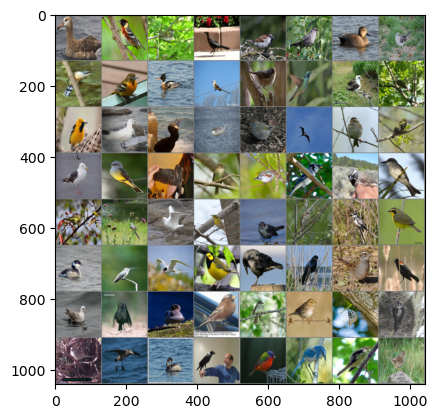

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))


In [57]:
#Step 2: Define a simple CNN model
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc = nn.Linear(16 * 64 * 64, num_classes)  # 16 channels * 64x64 image size
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.flatten(x)
        x = self.fc(x)
        return x
    
net = SimpleCNN()

In [58]:
# Step 2.1: Initialize the model
print(net)

# Step 3: Define a loss function and optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=65536, out_features=200, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [60]:

# train the network
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training
